# Importing libraries

In [12]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2

import argparse
import os
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, RandomSampler
from torchvision import datasets
from torch.autograd import Variable
import torch.nn.functional as F

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Required Parameters

In [13]:
os.makedirs("images_q2_autoen", exist_ok=True)

In [14]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 28, 28)
    return x

In [15]:
num_epochs = 20
batch_size = 20
learning_rate = 0.001

# Autoencoder 

In [16]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder_output = None
        self.encoder = nn.Sequential(
            nn.Linear(2352, 128),
            nn.ReLU(True),
            nn.Linear(128, 100))
        self.decoder = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(True), nn.Linear(128, 2352), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        self.encoder_output = x.detach().numpy()
        x = self.decoder(x)
        return x

In [17]:
model = autoencoder()
#print(model.encoder_output)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Loading the input data

In [18]:
root_dir = 'faces94'
files = glob(f"{root_dir}/**/**/*.jpg")

In [19]:
files[:10]

['faces94/malestaff/doraj/doraj.17.jpg',
 'faces94/malestaff/doraj/doraj.12.jpg',
 'faces94/malestaff/doraj/doraj.16.jpg',
 'faces94/malestaff/doraj/doraj.11.jpg',
 'faces94/malestaff/doraj/doraj.18.jpg',
 'faces94/malestaff/doraj/doraj.2.jpg',
 'faces94/malestaff/doraj/doraj.10.jpg',
 'faces94/malestaff/doraj/doraj.5.jpg',
 'faces94/malestaff/doraj/doraj.9.jpg',
 'faces94/malestaff/doraj/doraj.1.jpg']

3059


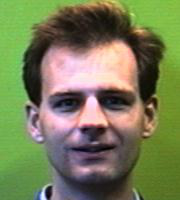

In [20]:
print(len(files))
Image.open(files[111])

In [28]:
c2i = {
    "female": 0,
    "male":1,
    "malestaff": 2 
}
i2l = {
    0: 'female', 
    1: 'male', 
    2:'malestaff'
}

In [29]:
transform_loader = transforms.Compose([
    transforms.RandomResizedCrop((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

all_imgs = torch.stack([transform_loader(Image.open(x)) for x in files])
all_label = torch.tensor([c2i[x.split('/')[-3]] for x in files])

train_idx, test_idx = train_test_split(range(len(all_imgs)), test_size=0.1, random_state=102)

train_img = all_imgs[train_idx]
train_label = all_label[train_idx]

test_img = all_imgs[test_idx]
test_label = all_label[test_idx]

train_data = TensorDataset(train_img, train_label)
test_data = TensorDataset(test_img, test_label)

train_samp = RandomSampler(train_data)
test_samp = SequentialSampler(test_data)

train_loader = DataLoader(train_data, sampler=train_samp, batch_size=32)
test_loader = DataLoader(test_data, sampler=test_samp, batch_size=32)
print("done")

done


# Training

In [30]:
loss_vals = []
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
       
        output = model(img)
        
        loss = criterion(output, img) 
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
    loss_vals.append(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    
    pic = to_img(output.data)
    save_image(pic, './images_q2_autoen/image_{}.png'.format(epoch))

epoch [1/20], loss:0.0912
epoch [2/20], loss:0.0725
epoch [3/20], loss:0.0695
epoch [4/20], loss:0.0193
epoch [5/20], loss:0.0569
epoch [6/20], loss:0.0777
epoch [7/20], loss:0.0565
epoch [8/20], loss:0.0321
epoch [9/20], loss:0.0383
epoch [10/20], loss:0.0398
epoch [11/20], loss:0.0241
epoch [12/20], loss:0.0540
epoch [13/20], loss:0.0607
epoch [14/20], loss:0.0512
epoch [15/20], loss:0.0468
epoch [16/20], loss:0.0388
epoch [17/20], loss:0.0461
epoch [18/20], loss:0.0667
epoch [19/20], loss:0.0601
epoch [20/20], loss:0.0164


# Writing the output to csv file

In [31]:
def write_csv():
    model.eval()
    with open('output.csv', 'w') as csv_file:
        for data in tqdm(train_loader):
            img, label  = data
            img = img.view(img.size(0),-1)
            img = Variable(img)
            with torch.no_grad():
                _ = model(img)
            enc = model.encoder_output
            for x,l in zip(enc, label):
                x = [str(q) + ',' for q in x]
                x = "".join(x) + i2l[l.item()] + '\n'
                csv_file.write(x)
        csv_file.close()
    with open('output.csv', 'a') as csv_file:
        for data in tqdm(test_loader):
            img, label  = data
            img = img.view(img.size(0),-1)
            img = Variable(img)
            with torch.no_grad():
                _ = model(img)
            enc = model.encoder_output
            for x,l in zip(enc, label):
                x = [str(q) + ',' for q in x]
                x = "".join(x) + i2l[l.item()] + '\n'
                csv_file.write(x)
        csv_file.close()

In [32]:
write_csv()

100%|██████████| 10/10 [00:00<00:00, 237.35it/s]


# Loss 

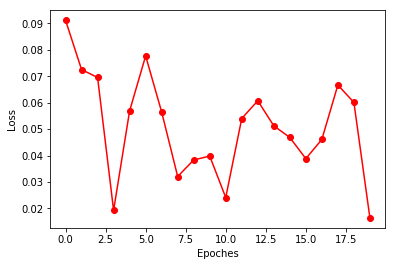

In [33]:
plt.plot(loss_vals,'ro-')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.show()